In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
torch.cuda.set_device(device)

In [4]:
from utils import load_cifar10, load_cifar100,load_tinyimagenet

In [5]:
# load cifar10 data
trainloader, testloader = load_cifar10(test_batch = 128)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# load dataloader for steal
stealloader,_ = load_cifar100()

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# load tinyimagenet for outlier exposure
outlier_loader = load_tinyimagenet()

# Steal Model 

## Attack comb net

- CombNet 에서 tau 설정 필요
- nb_stolen 으로 steal 시에 사용할 데이터 수 정할 수 있음

In [8]:
class args:
    save_dir = "../results"
    orig_model = "cifar_orig_net.pth"
    fake_model = "cifar_fake_random_net.pth"
    tau = 0.5
    nb_stolen = 50000 # attack model 학습시 사용할 데이터 수
    att_epochs = 50
    att_model = str(tau)+"_cifar_att_net.pth"

In [9]:
from cifar_models import Net, Net_logit, AttackNet
from utils import CombNet

In [10]:
import os
net = Net()
net.load_state_dict(torch.load(os.path.join(args.save_dir,args.orig_model),map_location='cpu'))
net_fake = Net()
net_fake.load_state_dict(torch.load(os.path.join(args.save_dir,args.fake_model),map_location='cpu'))
comb_net = CombNet(net, net_fake, tau=args.tau)

## train attack network

In [11]:
from utils import train_stmodel_comb, select_data,test_corr_model

In [11]:
att_net = AttackNet()

In [14]:
criterion_att = nn.CrossEntropyLoss()
optimizer_att = optim.SGD(att_net.parameters(), lr=0.001, momentum=0.9)

In [23]:
selected_loader = select_data(stealloader.dataset, args.nb_stolen, trainloader.batch_size, False)

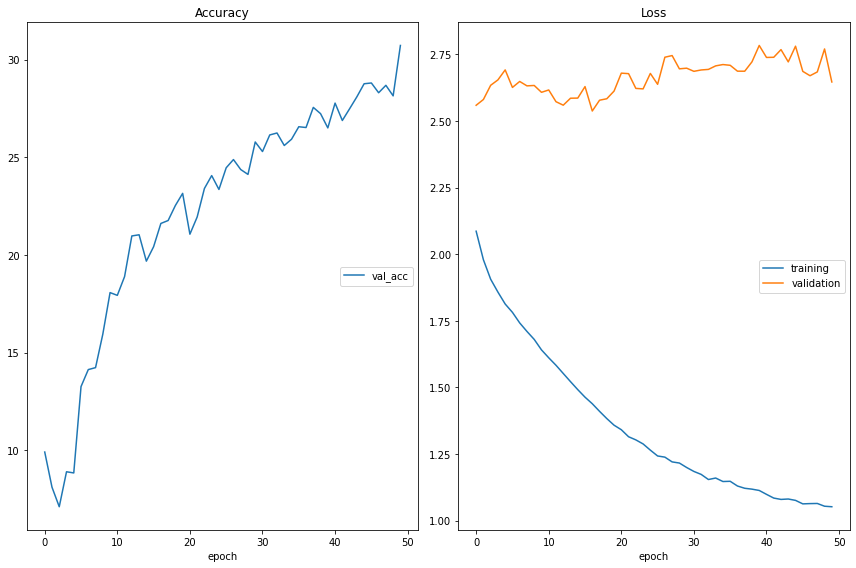

Accuracy
	val_acc          	 (min:    7.110, max:   30.720, cur:   30.720)
Loss
	training         	 (min:    1.052, max:    2.086, cur:    1.052)
	validation       	 (min:    2.537, max:    2.783, cur:    2.646)


In [56]:
att_net, logs_att = train_stmodel_comb(selected_loader, att_net, criterion_att, optimizer_att, comb_net, 
                                       epochs=args.att_epochs, device=device, test_loader=testloader, 
                                         save_dir = args.save_dir, 
                                       save_model=args.att_model)

## train attack network for multiple taus

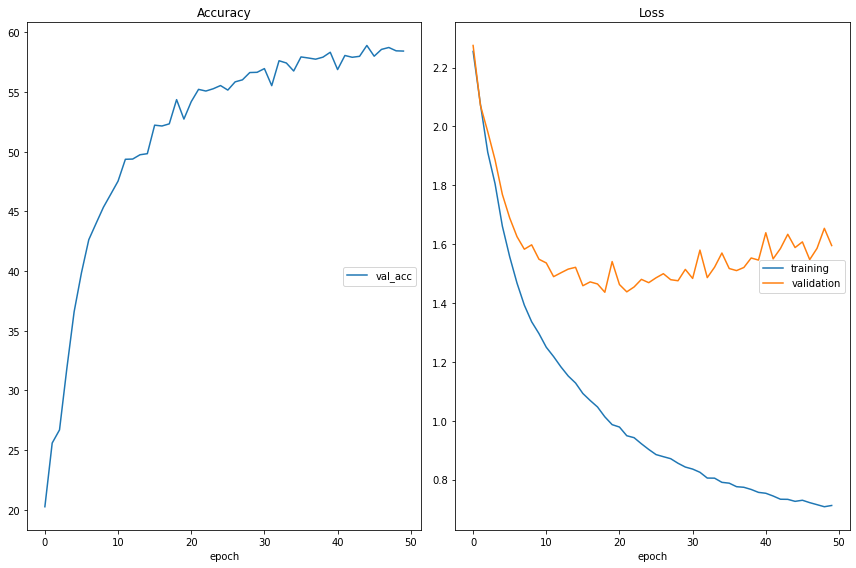

Accuracy
	val_acc          	 (min:   20.250, max:   58.910, cur:   58.440)
Loss
	training         	 (min:    0.708, max:    2.255, cur:    0.712)
	validation       	 (min:    1.437, max:    2.275, cur:    1.595)


NameError: name 'test_corr_model' is not defined

In [13]:
from utils import train_stmodel_comb, select_data,test_corr_model
import numpy as np
print(args)
selected_loader = select_data(stealloader.dataset, args.nb_stolen, trainloader.batch_size, False)

for tau in np.arange(0.1, 1.1, 0.1): 
    comb_net = CombNet(net, net_fake, tau=tau)
    att_net = AttackNet()
    criterion_att = nn.CrossEntropyLoss()
    optimizer_att = optim.SGD(att_net.parameters(), lr=0.001, momentum=0.9)
    print("train for tau",tau)
    _, logs_att = train_stmodel_comb(selected_loader, att_net, criterion_att, optimizer_att, comb_net, 
                                       epochs=args.att_epochs, device=device, test_loader=testloader, 
                                         save_dir = args.save_dir, 
                                       save_model=str(tau)+"_cifar_att_net.pth")
    loss1, loss2, acc1, acc2, corr = test_corr_model(comb_net, att_net, testloader, criterion_att, device)
    del loss1, loss2, acc1, acc2, corr, comb_net, att_net
    torch.cuda.empty_cache()

### load att net

In [15]:
att_net = AttackNet()
att_net.load_state_dict(torch.load(os.path.join(args.save_dir,args.att_model),map_location='cpu'))

<All keys matched successfully>

## test steal model

In [17]:
from utils import test_corr_model
criterion_att = nn.CrossEntropyLoss()
loss1, loss2, acc1, acc2, corr = test_corr_model(comb_net, att_net, testloader, criterion_att, device)

/home/srp/.pyenv/versions/pytorch19/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Accuracy/Loss 1: 39.96/2.1189
Accuracy/Loss 2: 30.72/2.6464
Correspondence:  tensor(57.6600)
